In [294]:
# import dependencies
import pandas as pd
import tensorflow as tf

In [295]:
# initialize spark
import findspark
findspark.init()

In [296]:
# import dependencies
from pyspark.sql import SparkSession
from pyspark import SparkFiles
import sklearn as skl

In [297]:
# initialize spark session
spark = SparkSession.builder.appName('SparkSQL').getOrCreate()

In [298]:
# use spark to read in csv to dataframe
spark.sparkContext.addFile('games_metadata_profile_2024_01.csv')
df = spark.read.csv(SparkFiles.get('games_metadata_profile_2024_01.csv'), header=True, inferSchema= True)

In [299]:
# create temporary view / table to use for queries
df.createOrReplaceTempView('chess')

In [300]:
# view dataframe
df.show()

+------+-----------------+-----+--------------------+----------+-------------------+---------------+--------+---------------+----------------+------------------+------------------+-----------------+--------------------+---------------+-----------+--------------------+--------+---------------+----------------+------------------+------------------+-----------------+--------------------+---------------+-----------+--------------------+----------+---+--------------------+-----------+------------+-------+
|GameID|            Event|Round|                Site|      Date|               Time|          White|WhiteElo|WhiteRatingDiff|White_is_deleted|White_tosViolation|White_profile_flag|  White_createdAt|White_playTime_total|White_count_all|White_title|               Black|BlackElo|BlackRatingDiff|Black_is_deleted|Black_tosViolation|Black_profile_flag|  Black_createdAt|Black_playTime_total|Black_count_all|Black_title|               Moves|TotalMoves|ECO|             Opening|TimeControl| Terminati

In [301]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all, TotalMoves,
Result from chess
WHERE Result != '*'
'''
).toPandas()

In [302]:
# drop null values
data.dropna(inplace=True)

In [303]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

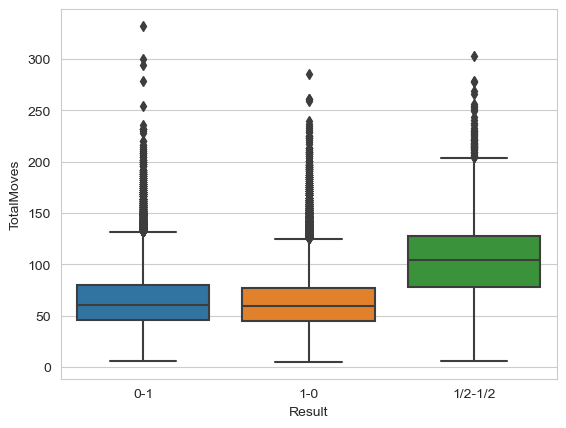

In [304]:
# create boxplot to explore difference between white and black victories with regard to total moves made
import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['TotalMoves'])

(-10000000.0, 10000000.0)

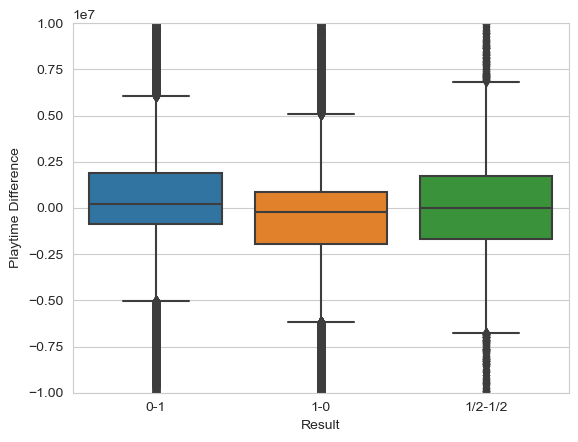

In [305]:
# create boxplot to explore difference between white and black victories with regard to difference in playtime
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Playtime Difference'])
ax.set_ylim(bottom = -10000000, top = 10000000)

(-30000.0, 30000.0)

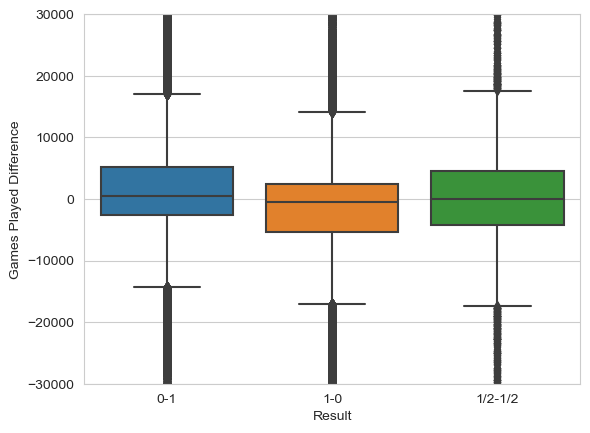

In [306]:
# create boxplot to explore difference between white and black victories with regard to number of games played
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Games Played Difference'])
ax.set_ylim(bottom = -30000, top = 30000)

(-200.0, 200.0)

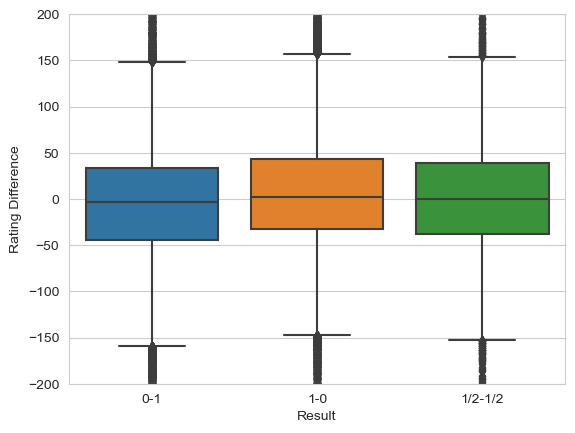

In [307]:
# create boxplot to explore difference between white and black victories with regard to difference in how the players are rated
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Rating Difference'])
ax.set_ylim(bottom = -200, top = 200)

(-600.0, 600.0)

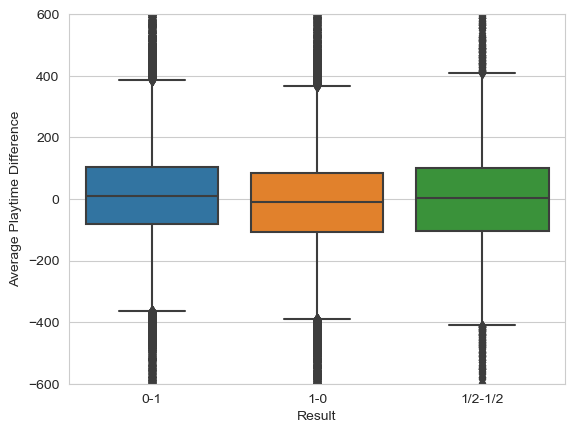

In [308]:
# create boxplot to explore difference between white and black victories with regard to average difference in playtime
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Average Playtime Difference'])
ax.set_ylim(bottom = -600, top = 600)

In [309]:
# drop features that are not categorical
data.drop(['WhiteElo','BlackElo','White_count_all','Black_count_all','White_playTime_total','Black_playTime_total'],axis=1,inplace=True)

## Linear Regression

In [310]:
y = data['Result']
X = pd.get_dummies(data.drop('Result', axis=1))
# split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [311]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [312]:
from sklearn.linear_model import LogisticRegression
linear = LogisticRegression(max_iter=1000)

linear.fit(X_train_scaled,y_train)

LogisticRegression(max_iter=1000)

In [313]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = linear.predict(X_test_scaled)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(classification_report(y_test,y_pred))

Accuracy Score: 0.5486458101269851
              precision    recall  f1-score   support

         0-1       0.54      0.39      0.45     14516
         1-0       0.55      0.73      0.63     15841
     1/2-1/2       0.26      0.05      0.08      1064

    accuracy                           0.55     31421
   macro avg       0.45      0.39      0.39     31421
weighted avg       0.54      0.55      0.53     31421



## Random Forest

In [314]:
# initiate a random forest model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=512, random_state=78)

In [315]:
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [316]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [317]:
# train the model with training data
rf_model = rf_model.fit(X_train_scaled, y_train)

In [318]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [319]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [320]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.6016040227873078
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.67      0.57      0.62     14516
  White Wins       0.68      0.67      0.67     15841
        Draw       0.00      0.00      0.00      1064

   micro avg       0.67      0.60      0.64     31421
   macro avg       0.45      0.41      0.43     31421
weighted avg       0.65      0.60      0.62     31421
 samples avg       0.60      0.60      0.60     31421



c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [321]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(importances, X.columns), reverse=True)

[(0.19507156071721687, 'TotalMoves'),
 (0.14279263196713235, 'Playtime Difference'),
 (0.13946888783574055, 'Games Played Difference'),
 (0.132768463350627, 'Rating Difference'),
 (0.13144882239692643, 'Average Playtime Difference'),
 (0.12963849311032632, 'White Average Playtime'),
 (0.12881114062203056, 'Black Average Playtime')]

## Sequential NN Model

In [322]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 256)               2048      
                                                                 
 dense_27 (Dense)            (None, 64)                16448     
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dense_30 (Dense)            (None, 3)                 195       
                                                                 
Total params: 27011 (105.51 KB)
Trainable params: 27011 (105.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [323]:
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [324]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100


2946/2946 [==============================] - 3s 767us/step - loss: 0.7881 - accuracy: 0.5488
Epoch 2/100
2946/2946 [==============================] - 2s 737us/step - loss: 0.7790 - accuracy: 0.5597
Epoch 3/100
2946/2946 [==============================] - 2s 732us/step - loss: 0.7757 - accuracy: 0.5669
Epoch 4/100
2946/2946 [==============================] - 2s 735us/step - loss: 0.7743 - accuracy: 0.5689
Epoch 5/100
2946/2946 [==============================] - 2s 725us/step - loss: 0.7727 - accuracy: 0.5722
Epoch 6/100
2946/2946 [==============================] - 2s 743us/step - loss: 0.7720 - accuracy: 0.5720
Epoch 7/100
2946/2946 [==============================] - 2s 720us/step - loss: 0.7710 - accuracy: 0.5733
Epoch 8/100
2946/2946 [==============================] - 2s 731us/step - loss: 0.7707 - accuracy: 0.5743
Epoch 9/100
2946/2946 [==============================] - 2s 725us/step - loss: 0.7701 - accuracy: 0.5765
Epoch 10/100
2946/2946 [==============================] - 2s 734us/

## Hyperparameter Tuning

In [325]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid','softmax','swish'])
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=512,
        step=5), activation=activation, input_dim=len(X_train.columns)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 8)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=512,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=3, activation='softmax'))

    # Compile the model
    nn_model.compile(loss="CategoricalCrossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [326]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2,
    overwrite=True)

In [327]:
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 01m 56s]
val_accuracy: 0.5763979554176331

Best val_accuracy So Far: 0.5787212252616882
Total elapsed time: 00h 37m 56s


In [328]:
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'relu', 'first_units': 441, 'num_layers': 6, 'units_0': 251, 'units_1': 96, 'units_2': 156, 'units_3': 396, 'units_4': 16, 'units_5': 121, 'units_6': 116, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0018', 'units_7': 11}
{'activation': 'relu', 'first_units': 166, 'num_layers': 2, 'units_0': 236, 'units_1': 6, 'units_2': 221, 'units_3': 456, 'units_4': 386, 'units_5': 156, 'units_6': 281, 'units_7': 381, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0042'}
{'activation': 'relu', 'first_units': 256, 'num_layers': 2, 'units_0': 76, 'units_1': 281, 'units_2': 101, 'units_3': 36, 'units_4': 431, 'units_5': 216, 'units_6': 136, 'units_7': 196, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0050'}


In [329]:
best_model = tuner.get_best_models()[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

982/982 - 1s - loss: 0.7691 - accuracy: 0.5787 - 802ms/epoch - 817us/step
Loss: 0.769116997718811, Accuracy: 0.5787212252616882


## Binning Outliers in Rating Difference

In [330]:
bins = [-2000, -1000, -500, -150, -50, 0, 50, 150, 500, 1000, 2000]
data['Rating Difference'] = pd.cut(data['Rating Difference'], bins)

In [331]:
data['Rating Difference'].head()

0      (50, 150]
1    (-150, -50]
2       (-50, 0]
3       (-50, 0]
4       (-50, 0]
Name: Rating Difference, dtype: category
Categories (10, interval[int64, right]): [(-2000, -1000] < (-1000, -500] < (-500, -150] < (-150, -50] ... (50, 150] < (150, 500] < (500, 1000] < (1000, 2000]]

In [332]:
# dummy encode the categorical data and sort into target and features
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))

In [333]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [334]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [335]:
# initiate a random forest model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=512, random_state=78)

In [336]:
# train the model with training data
rf_model = rf_model.fit(X_train_scaled, y_train)

In [337]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [338]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [339]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.5837497215238217
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.65      0.55      0.60     14516
  White Wins       0.66      0.65      0.65     15841
        Draw       0.00      0.00      0.00      1064

   micro avg       0.65      0.58      0.62     31421
   macro avg       0.43      0.40      0.42     31421
weighted avg       0.63      0.58      0.61     31421
 samples avg       0.58      0.58      0.58     31421



c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [340]:
# Calculating feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(importances, X.columns), reverse=True)

[(0.20417716258915353, 'TotalMoves'),
 (0.16008715376553523, 'Playtime Difference'),
 (0.15679306866432044, 'Games Played Difference'),
 (0.14858828998382126, 'Average Playtime Difference'),
 (0.14661640016872798, 'White Average Playtime'),
 (0.14642235984674798, 'Black Average Playtime'),
 (0.007563483583772837, 'Rating Difference_(-50, 0]'),
 (0.00738571955451873, 'Rating Difference_(0, 50]'),
 (0.005389051272143455, 'Rating Difference_(-150, -50]'),
 (0.004439173176373118, 'Rating Difference_(-500, -150]'),
 (0.004362699279370156, 'Rating Difference_(150, 500]'),
 (0.004288556761098735, 'Rating Difference_(50, 150]'),
 (0.0016191535146478657, 'Rating Difference_(500, 1000]'),
 (0.0016089741538236977, 'Rating Difference_(-1000, -500]'),
 (0.0004122208829182406, 'Rating Difference_(-2000, -1000]'),
 (0.0002465328030266965, 'Rating Difference_(1000, 2000]')]

In [341]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="mish")
)

# Further hidden layers
nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               4352      
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 3)                 195       
                                                                 
Total params: 29315 (114.51 KB)
Trainable params: 29315 (114.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [342]:
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [343]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100


2946/2946 [==============================] - 3s 787us/step - loss: 0.7897 - accuracy: 0.5414
Epoch 2/100
2946/2946 [==============================] - 2s 784us/step - loss: 0.7813 - accuracy: 0.5547
Epoch 3/100
2946/2946 [==============================] - 2s 801us/step - loss: 0.7788 - accuracy: 0.5606
Epoch 4/100
2946/2946 [==============================] - 2s 788us/step - loss: 0.7774 - accuracy: 0.5623
Epoch 5/100
2946/2946 [==============================] - 2s 808us/step - loss: 0.7762 - accuracy: 0.5648
Epoch 6/100
2946/2946 [==============================] - 2s 809us/step - loss: 0.7757 - accuracy: 0.5655
Epoch 7/100
2946/2946 [==============================] - 2s 805us/step - loss: 0.7749 - accuracy: 0.5672
Epoch 8/100
2946/2946 [==============================] - 2s 804us/step - loss: 0.7746 - accuracy: 0.5691
Epoch 9/100
2946/2946 [==============================] - 2s 793us/step - loss: 0.7738 - accuracy: 0.5691
Epoch 10/100
2946/2946 [==============================] - 2s 803us/

## Dropping Outliers

In [344]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all, TotalMoves,
Result from chess
WHERE Result != '*'
'''
).toPandas()

In [345]:
# drop null values
data.dropna(inplace=True)

In [346]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

In [347]:
# drop features that are not categorical
data.drop(['WhiteElo','BlackElo','White_count_all','Black_count_all','White_playTime_total','Black_playTime_total'],axis=1,inplace=True)

In [348]:
indices = data.loc[(data['Rating Difference']>150) | (data['Rating Difference'] < -150)].index
data.drop(indices, inplace=True)

In [349]:
# dummy encode the categorical data and sort into target and features
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))

In [350]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [351]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [352]:
# initiate a random forest model
rf_model = RandomForestClassifier(n_estimators=512, random_state=78)

In [353]:
# train the model with training data
rf_model = rf_model.fit(X_train_scaled, y_train)

In [354]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [355]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [356]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

Accuracy Score : 0.5814647118010636
Classification Report
              precision    recall  f1-score   support

  Black Wins       0.65      0.55      0.60     12913
  White Wins       0.66      0.65      0.66     13906
        Draw       0.00      0.00      0.00      1009

   micro avg       0.66      0.58      0.62     27828
   macro avg       0.44      0.40      0.42     27828
weighted avg       0.63      0.58      0.60     27828
 samples avg       0.58      0.58      0.58     27828



c:\Users\Ian\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [357]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(importances, X.columns), reverse=True)

[(0.191778840137576, 'TotalMoves'),
 (0.1471740552200985, 'Playtime Difference'),
 (0.1425252046381483, 'Games Played Difference'),
 (0.13320336964671026, 'Average Playtime Difference'),
 (0.1308705941197838, 'White Average Playtime'),
 (0.13008736510204572, 'Black Average Playtime'),
 (0.12436057113563752, 'Rating Difference')]

In [358]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="mish")
)

# Further hidden layers
nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 256)               2048      
                                                                 
 dense_14 (Dense)            (None, 64)                16448     
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 3)                 195       
                                                                 
Total params: 27011 (105.51 KB)
Trainable params: 27011 (105.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [359]:
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [360]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Epoch 1/20


2609/2609 [==============================] - 3s 1ms/step - loss: 0.7909 - accuracy: 0.5437 - val_loss: 0.7840 - val_accuracy: 0.5570
Epoch 2/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7811 - accuracy: 0.5593 - val_loss: 0.7801 - val_accuracy: 0.5641
Epoch 3/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7789 - accuracy: 0.5625 - val_loss: 0.7842 - val_accuracy: 0.5606
Epoch 4/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7778 - accuracy: 0.5646 - val_loss: 0.7795 - val_accuracy: 0.5650
Epoch 5/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7769 - accuracy: 0.5670 - val_loss: 0.7779 - val_accuracy: 0.5648
Epoch 6/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7763 - accuracy: 0.5667 - val_loss: 0.7783 - val_accuracy: 0.5629
Epoch 7/20
2609/2609 [==============================] - 3s 1ms/step - loss: 0.7759 - accuracy: 0.5675 - val_loss: 0.7784 - val_accuracy: 0.5634
Epo

## Adding Dropout and Normalization Layers

In [361]:
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [362]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [363]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="mish")
)
# Adding dropout layer
nn.add(tf.keras.layers.Dropout(0.3))

# Adding Normalization layer
nn.add(tf.keras.layers.BatchNormalization())

# Further hidden layers
nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dropout(0.3))

nn.add(tf.keras.layers.BatchNormalization())

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dropout(0.3))

nn.add(tf.keras.layers.BatchNormalization())

nn.add(tf.keras.layers.Dense(units=64, activation="mish"))

nn.add(tf.keras.layers.Dropout(0.3))

nn.add(tf.keras.layers.BatchNormalization())

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               2048      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                     

In [364]:
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [365]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Epoch 1/20


2609/2609 [==============================] - 5s 2ms/step - loss: 0.8415 - accuracy: 0.5197 - val_loss: 0.7918 - val_accuracy: 0.5447
Epoch 2/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7927 - accuracy: 0.5443 - val_loss: 0.7847 - val_accuracy: 0.5545
Epoch 3/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7894 - accuracy: 0.5497 - val_loss: 0.7838 - val_accuracy: 0.5563
Epoch 4/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7875 - accuracy: 0.5513 - val_loss: 0.7845 - val_accuracy: 0.5515
Epoch 5/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7869 - accuracy: 0.5519 - val_loss: 0.7878 - val_accuracy: 0.5538
Epoch 6/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7869 - accuracy: 0.5525 - val_loss: 0.7825 - val_accuracy: 0.5588
Epoch 7/20
2609/2609 [==============================] - 4s 2ms/step - loss: 0.7854 - accuracy: 0.5555 - val_loss: 0.7824 - val_accuracy: 0.5633
Epo

## XGBoost

In [366]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [367]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [368]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [369]:
from xgboost import XGBClassifier
xg_nn = XGBClassifier(n_estimators = 256, max_depth = 32, objective ='multi:softmax')
xg_nn.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [370]:
predictions = xg_nn.predict(X_test_scaled)

In [371]:
accuracy_score(y_test, predictions)

0.9002443582003737

In [372]:
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

              precision    recall  f1-score   support

  Black Wins       0.90      0.93      0.91     12913
  White Wins       0.91      0.93      0.92     13906
        Draw       0.24      0.03      0.06      1009

    accuracy                           0.90     27828
   macro avg       0.68      0.63      0.63     27828
weighted avg       0.88      0.90      0.89     27828



In [373]:
from sklearn.metrics import confusion_matrix
cm_df = pd.DataFrame(confusion_matrix(y_test, predictions,))

[Text(0, 0.5, 'Black Wins'), Text(0, 1.5, 'White Wins'), Text(0, 2.5, 'Draw')]

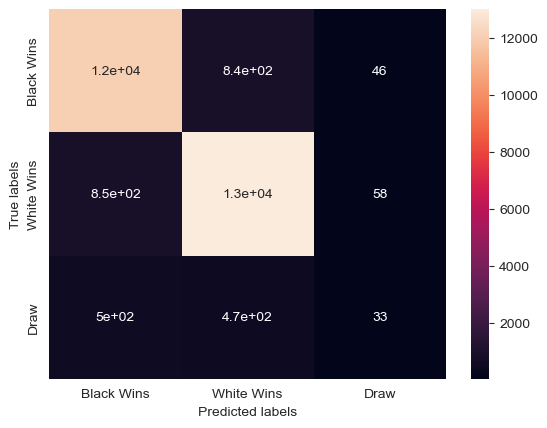

In [374]:
ax = sns.heatmap(cm_df,annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw']); ax.yaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw'])

## Upsampling Draws

In [375]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X,y)

In [376]:
y_resampled.value_counts()

Result
0    55688
1    55688
2    55688
Name: count, dtype: int64

In [377]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=78)

In [378]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [379]:
xg_nn = XGBClassifier(n_estimators = 256, max_depth = 32, objective ='multi:softmax')
xg_nn.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [380]:
predictions = xg_nn.predict(X_test_scaled)

In [381]:
accuracy_score(y_test, predictions)

0.8192548963271561

In [382]:
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

              precision    recall  f1-score   support

  Black Wins       0.84      0.79      0.82     14023
  White Wins       0.82      0.83      0.82     13904
        Draw       0.80      0.84      0.82     13839

    accuracy                           0.82     41766
   macro avg       0.82      0.82      0.82     41766
weighted avg       0.82      0.82      0.82     41766



In [383]:
from sklearn.metrics import confusion_matrix
cm_df = pd.DataFrame(confusion_matrix(y_test, predictions,))

[Text(0, 0.5, 'Black Wins'), Text(0, 1.5, 'White Wins'), Text(0, 2.5, 'Draw')]

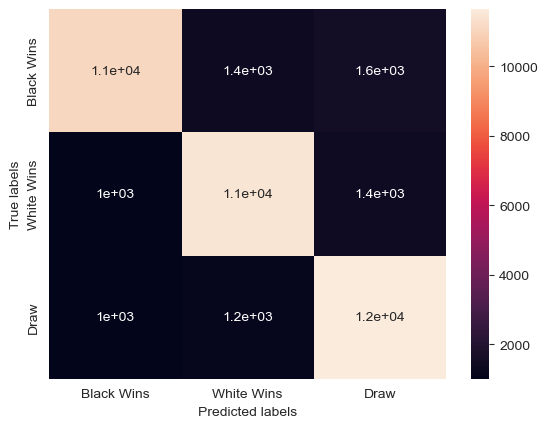

In [384]:
ax = sns.heatmap(cm_df,annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw']); ax.yaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw'])

## A Purely Predictive Model

In [385]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all,TimeControl,
Result from chess
WHERE Result != '*'
'''
).toPandas()

In [386]:
# drop null values
data.dropna(inplace=True)

In [387]:
# create features exploring the differences in white versus black to use in prediction model
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

In [388]:
# drop features that are not significant or are repeated in other features
data.drop(['WhiteElo','BlackElo','White_count_all','Black_count_all','White_playTime_total','Black_playTime_total'],axis=1,inplace=True)

In [389]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [390]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [391]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [392]:
from xgboost import XGBClassifier
xg_nn = XGBClassifier(n_estimators = 256, max_depth = 32, objective ='multi:softmax')
xg_nn.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [393]:
predictions = xg_nn.predict(X_test_scaled)

In [394]:
accuracy_score(y_test, predictions)

0.5383978867636294

In [395]:
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

              precision    recall  f1-score   support

  Black Wins       0.52      0.52      0.52     14516
  White Wins       0.56      0.59      0.57     15841
        Draw       0.02      0.00      0.00      1064

    accuracy                           0.54     31421
   macro avg       0.37      0.37      0.36     31421
weighted avg       0.52      0.54      0.53     31421



In [396]:
from sklearn.metrics import confusion_matrix
cm_df = pd.DataFrame(confusion_matrix(y_test, predictions,))

[Text(0, 0.5, 'Black Wins'), Text(0, 1.5, 'White Wins'), Text(0, 2.5, 'Draw')]

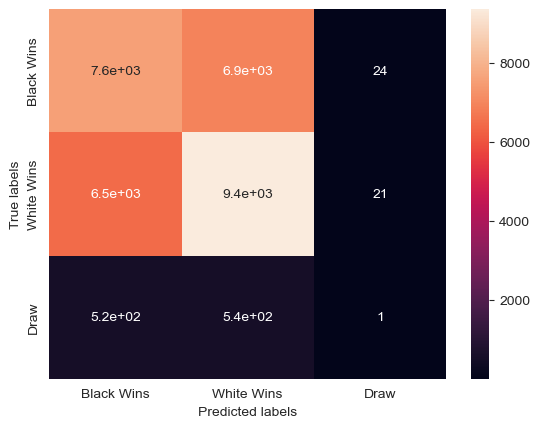

In [397]:
ax = sns.heatmap(cm_df,annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw']); ax.yaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw'])

In [398]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X,y)

In [399]:
y_resampled.value_counts()

Result
0    62880
1    62880
2    62880
Name: count, dtype: int64

In [400]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=78)

In [401]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [402]:
xg_nn = XGBClassifier(n_estimators = 256, max_depth = 32, objective ='multi:softmax')
xg_nn.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [403]:
predictions = xg_nn.predict(X_test_scaled)

In [404]:
accuracy_score(y_test, predictions)

0.6617472434266327

In [405]:
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

              precision    recall  f1-score   support

  Black Wins       0.53      0.51      0.52     15675
  White Wins       0.54      0.57      0.56     15739
        Draw       0.92      0.90      0.91     15746

    accuracy                           0.66     47160
   macro avg       0.66      0.66      0.66     47160
weighted avg       0.66      0.66      0.66     47160



In [406]:
from sklearn.metrics import confusion_matrix
cm_df = pd.DataFrame(confusion_matrix(y_test, predictions,))

[Text(0, 0.5, 'Black Wins'), Text(0, 1.5, 'White Wins'), Text(0, 2.5, 'Draw')]

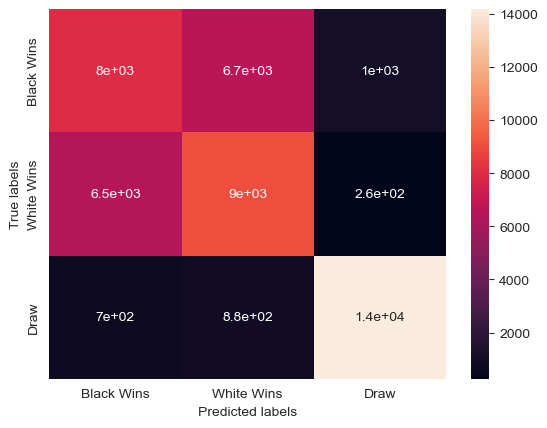

In [407]:
ax = sns.heatmap(cm_df,annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw']); ax.yaxis.set_ticklabels(['Black Wins', 'White Wins', 'Draw'])

## Adding in More Features

In [408]:
# select relevant columns of data and save as pandas dataframe
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all,TotalMoves,Termination,TimeControl,ECO,
Result from chess
WHERE Result != '*'
'''
).toPandas()

In [409]:
# drop null values
data.dropna(inplace=True)

In [410]:
data['TimeControl'] = data['TimeControl'].str.split('+').str[0]

In [411]:
# dummy encode the categorical data and sort into target and features
resultmap = {'0-1':0, '1-0':1, '1/2-1/2':2}
y = data['Result'].map(resultmap)
X = pd.get_dummies(data.drop('Result', axis=1))

In [412]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [413]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [414]:
xg_nn = XGBClassifier(n_estimators = 256, max_depth = 32, objective ='multi:softmax')
xg_nn.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=256, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [415]:
predictions = xg_nn.predict(X_test_scaled)

In [416]:
accuracy_score(y_test, predictions)

0.9032812450272111

In [417]:
print(classification_report(y_test, predictions, target_names=['Black Wins', 'White Wins', 'Draw']))

              precision    recall  f1-score   support

  Black Wins       0.90      0.93      0.92     14516
  White Wins       0.91      0.94      0.92     15841
        Draw       0.25      0.04      0.07      1064

    accuracy                           0.90     31421
   macro avg       0.69      0.64      0.64     31421
weighted avg       0.88      0.90      0.89     31421



In [418]:
pd.DataFrame({'Feature Name':X.columns,'Importances':xg_nn.feature_importances_}).sort_values(by='Importances',ascending=False).head(50)

,Feature Name,Importances
6,TotalMoves,0.031602
316,ECO_C80,0.017044
181,ECO_B38,0.016966
374,ECO_D40,0.013599
131,ECO_A85,0.013064
162,ECO_B19,0.011128
7,Termination_Normal,0.010235
157,ECO_B14,0.009075
27,TimeControl_30,0.008171
99,ECO_A49,0.007303
